In [ ]:
%load_ext autoreload
%autoreload 2

import os
import config
os.chdir(config.PROJECT_ROOT_PATH)

import torch
from torchvision.transforms.functional import to_pil_image, pil_to_tensor
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pylab import rcParams
rcParams['figure.figsize'] = 4,3
%matplotlib inline

import fitz
from PIL import Image
from tqdm.auto import tqdm
import json

from src.faster_rcnn.model import create_model
from src.processing.visualising import draw_img

import warnings
warnings.filterwarnings('ignore')

from pytesseract import pytesseract
pytesseract.tesseract_cmd = r'/usr/bin/tesseract'
import pandas as pd

import enchant
english_dict = enchant.Dict('en_US')
russian_dict = enchant.Dict('ru_RU')

import subprocess
import shutil

In [ ]:
!export TESSDATA_PREFIX=/usr/local/share/

In [ ]:
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE = 'cpu'

In [ ]:
model = create_model(config, mode='custom', name='monocrome_last').to(DEVICE)
model.eval()
pass

In [ ]:
def num_generator():
    i = 0
    while True:
        yield i
        i += 1
next_num = num_generator()

class Paragraph:
    def __init__(self, df):
        self.df = df

    def __str__(self):
        return 'PARAGRAPH:\n' +  ' '.join(list(self.df.text))

    def in_latex_format(self):
        return ' '.join(list(self.df.text))

class Section:
    def __init__(self, df):
        self.df = df

    def __str__(self):
        return 'SECTION:\n' + ' '.join(list(self.df.text))

    def in_latex_format(self):
        return r'\section{' + ' '.join(list(self.df.text)) + '}'

class Chapter:
    def __init__(self, df):
        self.df = df

    def __str__(self):
        return 'CHAPTER:\n' + ' '.join(list(self.df.text))

    def in_latex_format(self):
        return r'\chapter{' + ' '.join(list(self.df.text)) + '}'

class Img:
    def __init__(self, img):
        self.img = img
        self.num = str(next(next_num))
        self.path=config.IMGS_SAVE_PATH.joinpath(f'img{self.num}.png')
        self.img.save(self.path)
        self.w, self.h = img.size

    def __str__(self):
        return 'IMG:\n' + str(self.path)

    def in_latex_format(self):
        return r'''
\begin{figure}[!h]
\centering
\includegraphics[width=10cm, height=''' + str(10*self.h/self.w) + 'cm]{' + str(self.path) + '''}
\caption{}
\end{figure}
        '''


  0%|          | 0/7 [00:00<?, ?it/s]

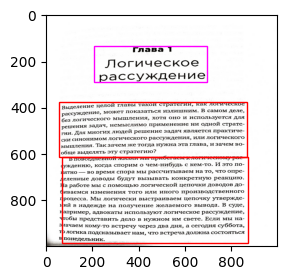

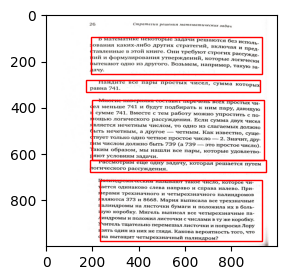

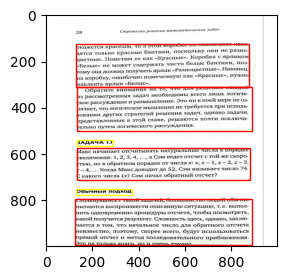

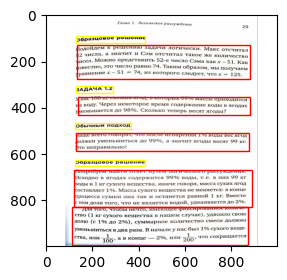

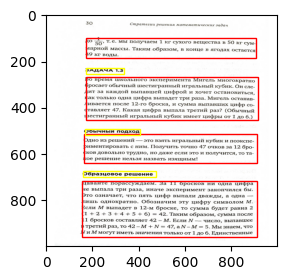

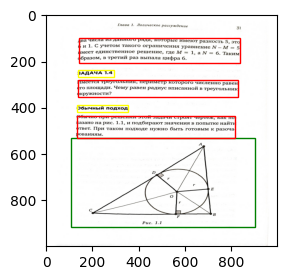

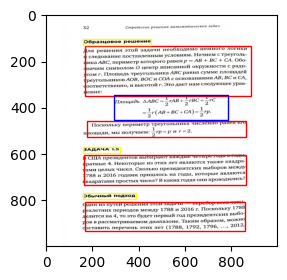

In [30]:
def process_paragraph(df):
    df = df[['par_num', 'line_num', 'text']]

    paragraphs = []
    for par_num in df.par_num.unique():
        df_par = df[(df.par_num == par_num) & (df.text.notna())]
        df_par.text = df_par.text.apply(str)
        line_nums = list(df_par.line_num.unique())

        if not line_nums:
            continue

        for l1, l2 in zip([0] + line_nums, line_nums):
            if l1 == 0:
                continue
            idx1 = df_par.loc[df_par.line_num == l1].index[-1]
            idx2 = df_par.loc[df_par.line_num == l2].index[0]
            w1 = df_par.loc[idx1, 'text']
            w2 = df_par.loc[idx2, 'text']
            if w1[-1] == '-':
                dashed = w1+w2
                not_dashed = w1[:-1]+w2
                if english_dict.check(dashed) and not english_dict.check(not_dashed):
                    df_par.loc[idx1, 'text'] = dashed
                else:
                    df_par.loc[idx1, 'text'] = not_dashed
                df_par.loc[idx2, 'text'] = ''

        df_par.text = df_par.text.apply(str.strip)
        df_par = df_par[~(df_par['text'].str.isspace()) & ~(df_par['text'].eq(''))]
        paragraphs.append(Paragraph(df_par))

    return paragraphs

def process_header(df):
    df = df[['par_num', 'line_num', 'text']]
    df = df[df.text.notna()]
    df.text = df.text.apply(str)
    return [Section(df)]

def process_chapter(df):
    df = df[['par_num', 'line_num', 'text']]
    df = df[df.text.notna()]
    df.text = df.text.apply(str)
    return [Chapter(df)]

def process_img(pix):
    return [Img(pix)]

class Processor:
    def __init__(self, config, model, score_thresh=0.75):
        self.config = config
        self.dpi=200
        self.DEVICE =  DEVICE
        self.model = model.to(self.DEVICE)
        self.model.eval()
        self.score_thresh = score_thresh

    def _page_to_torch(self, page):
        pix = page.get_pixmap(dpi=self.dpi)
        img = Image.frombytes("RGB", (pix.width, pix.height), pix.samples)
        img = img.resize((1000,1000))
        img = pil_to_tensor(img)
        return img

    def _doc_to_tensor(self, doc):
        imgs = torch.stack([self._page_to_torch(page) for page in doc], dim=0)
        # imgs = torch.from_numpy(np.array(pages)).float()
        # imgs = imgs.permute(0, 3, 1, 2)
        imgs = imgs.to(DEVICE)
        return imgs/255

    def _process_preds(self, preds):
        labels = preds['labels'].cpu()
        bboxes = preds['boxes'].cpu()
        scores = preds['scores'].cpu()
        fl = []
        fb = []
        for l, b, s in zip(labels, bboxes, scores):
            if s >= self.score_thresh:
                fl.append(l.item())
                fb.append(b.tolist())

        return fl, fb

    def _get_bbox_pic(self, page_img, bbox):
        width, height = page_img.size
        xscale, yscale = width/1000, height/1000
        x1, y1, x2, y2 = bbox
        x1=int(x1*xscale)
        x2=int(x2*xscale)
        y1=int(y1*yscale)
        y2=int(y2*yscale)

        x1 = max(0, x1-20)
        x2 = min(width, x2+20)

        target_segment = page_img.crop((x1, y1, x2, y2))
        return target_segment

    def _extract_text(self, image):
        return pytesseract.image_to_data(image, lang='rus+eng', output_type=pytesseract.Output.DATAFRAME)

    def parse_doc(self, path):
        doc = fitz.open(path)

        tensored = self._doc_to_tensor(doc)
        with torch.no_grad():
            doc_predictions = self.model(tensored)

        result = []
        pages = list(page for page in doc)

        for page, page_predictions in tqdm(list(zip(pages, doc_predictions))):
            result.extend(self._parse_page(page, page_predictions))
        return result

    def _parse_page(self, page, predictions):
        pix = page.get_pixmap(dpi=self.dpi)
        page_img = Image.frombytes("RGB", (pix.width, pix.height), pix.samples)
        labels, bboxes = self._process_preds(predictions)

        draw_img(page_img.resize((1000,1000)), labels=labels, bboxes=bboxes)

        objects_on_page = []
        for l, bb in sorted(zip(labels, bboxes), key=lambda x: x[1][1]):
            pic = self._get_bbox_pic(page_img, bb)
            classname = self.config.CLASSNUM_TO_CLASSNAME[l]
            if classname in 'text chapter section'.split():
                text_df = self._extract_text(pic)
                if classname == 'text':
                    paragraphs = process_paragraph(text_df)
                    objects_on_page.extend(paragraphs)
                elif classname == 'chapter':
                    chapters = process_chapter(text_df)
                    objects_on_page.extend(chapters)
                elif classname == 'section':
                    headers = process_header(text_df)
                    objects_on_page.extend(headers)
            elif classname in 'formula img'.split():
                    imgs = process_img(pic)
                    objects_on_page.extend(imgs)

        return objects_on_page

p = Processor(
    config=config,
    model=model,
    score_thresh=0.7
)

doc_content = p.parse_doc(config.PDF_TO_PROCESS)

In [31]:
with open(config.LATEX_RESULT_PATH.joinpath('content.tex'), 'w') as f:
    for element in doc_content:
        f.write(element.in_latex_format().replace('_', '\_').replace('%', '\%'))
        f.write('\n\n')

In [32]:
os.chdir(config.LATEX_RESULT_PATH)

proc1 = subprocess.Popen("pdflatex -synctex=1 -interaction=nonstopmode main.tex".split())
output, error = proc1.communicate()
print(output, error)
shutil.copyfile('main.pdf', config.root.joinpath('outputs', 'result.pdf'))

None None


PosixPath('/home/f/Programming/projects/scans_to_pdf_cg_cv/outputs/result.pdf')